[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/07_ulysses_compass.ipynb)

# Chapter 7 - Ulysses' Compass


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.1
tensorflow 2.1.0
tensorflow_probability 0.9.0
arviz 0.6.1
scipy 1.4.1
pandas 0.25.3


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
assert tf.__version__ >= '2.1.0', "Tensorflow version should be at minimum 2.1.0"
assert tfp.__version__ >= '0.9.0', "TFP version should be at minimum 0.9.0"

## Tensorflow MCMC Sampling helpers


In [7]:
USE_XLA = False

In [8]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )


class HMCSampler(object):

    @tf.function(autograph=False, experimental_compile=USE_XLA)
    def run_chain(init_state,
                  bijectors, 
                  step_size, 
                  target_log_prob_fn, 
                  num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
                  num_samples=NUMBER_OF_SAMPLES,
                  burnin=NUMBER_OF_BURNIN,
                  ):    

        def _trace_fn_transitioned(_, pkr):
            return (
                pkr.inner_results.inner_results.log_accept_ratio
            )
        
        hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                        target_log_prob_fn,
                        num_leapfrog_steps=num_leapfrog_steps,
                        step_size=step_size)         

        inner_kernel = tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=hmc_kernel,
            bijector=bijectors)       

        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            inner_kernel=inner_kernel,
            target_accept_prob=.8,
            num_adaptation_steps=int(0.8*burnin),
            log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
        )    

        results, sampler_stat = tfp.mcmc.sample_chain(
            num_results=num_samples,
            num_burnin_steps=burnin,
            current_state=init_state,
            kernel=kernel,
            trace_fn=_trace_fn_transitioned)

        return results, sampler_stat
    
    def sample_from_posterior(jdc, 
                              observed_data, 
                              params, 
                              init_state, 
                              bijectors,                              
                              num_samples=NUMBER_OF_SAMPLES, 
                              burnin=NUMBER_OF_BURNIN):       

        
        target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    

        step_size = 0.1
        
        results, sample_stats = HMCSampler.run_chain(init_state,
                                      bijectors,
                                      step_size=step_size,
                                      target_log_prob_fn=target_log_prob_fn,                                      
                                      num_samples=num_samples, 
                                      burnin=burnin)

        stat_names = ['mean_tree_accept']
        sampler_stats = dict(zip(stat_names, [sample_stats]))    
        
        posterior = dict(zip(params, results))

        return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

In [9]:
sample_from_posterior = HMCSampler.sample_from_posterior

## Dataset URLs


In [10]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/ksachdeva/rethinking-tensorflow-probability/master/data"

WAFFLE_DIVORCE_DATASET_PATH = f"{_BASE_URL}/WaffleDivorce.csv"
CARS_DATASET_PATH = f"{_BASE_URL}/cars.csv"

## Code 7.1


Below is a dataset for average brain volumes and body masses for 7 hominin species

In [11]:
sppnames = ["afarensis", "africanus", "habilis", "boisei",
            "rudolfensis", "ergaster", "sapiens"]
brainvolcc = np.array([438, 452, 612, 521, 752, 871, 1350])
masskg = np.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})

d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


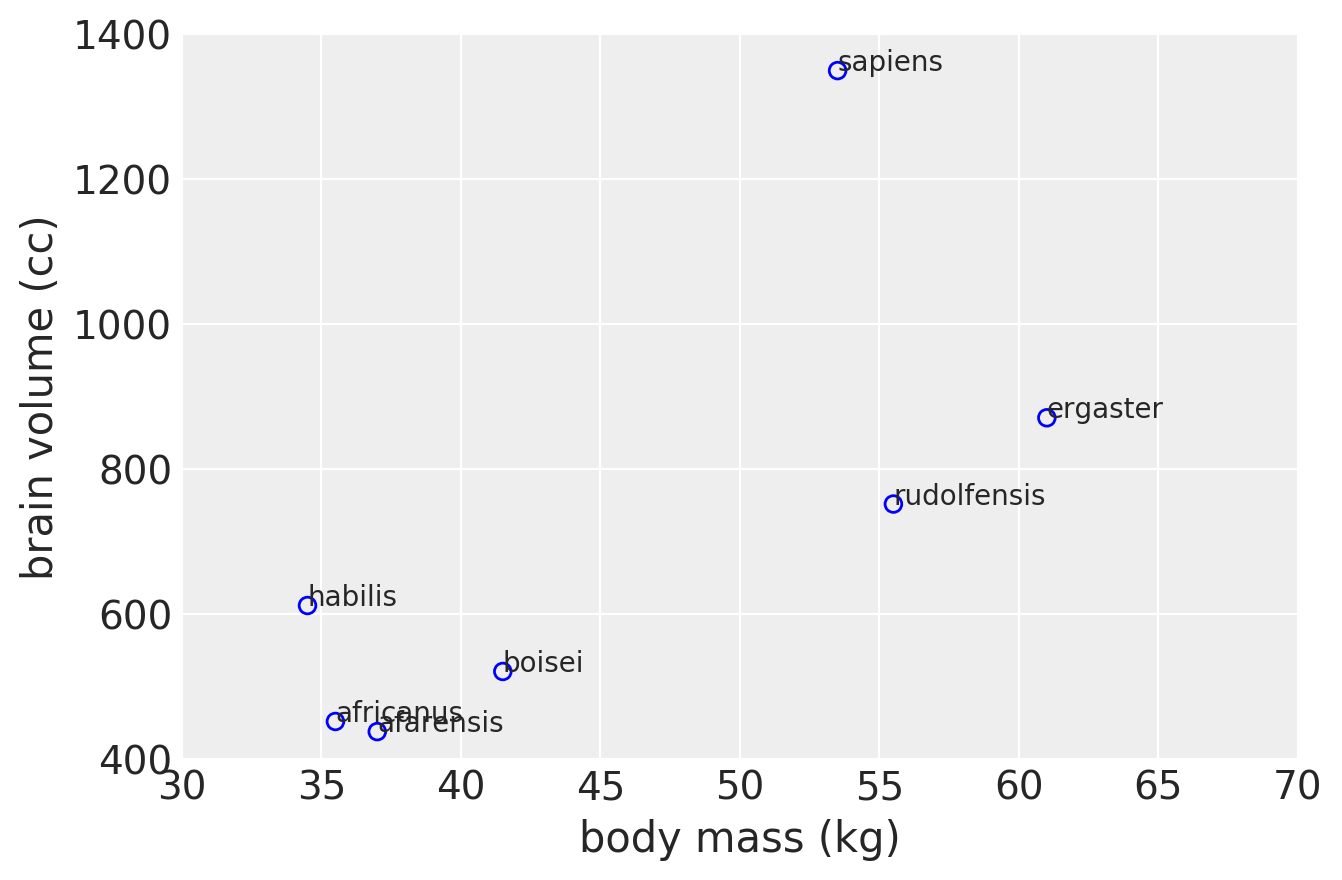

In [12]:
# Reproducing the figure in the book (there is no code fragment for this in R in the book)
plt.scatter(d.mass, d.brain, facecolors="none", edgecolors="b")
plt.gca().set(xlim=(30, 70), xlabel="body mass (kg)",
              ylim=(400,1400),
              ylabel="brain volume (cc)")

for i in range(d.shape[0]):
    plt.annotate(d.species[i], (d.mass[i], d.brain[i]))

## Code 7.2


Author talks about linear vs polynomial regression. He is of the opinion that most of the time polynomial regression is not a good idea (at least when used blindly). But why ?

In [13]:
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()

Note - brain is not standardized as such because you can not have -ive brain

## Code 7.3

Simplest model is the linear one and this is what we will start with

In [14]:
def model_7_1(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + beta[...,tf.newaxis] * mass_std
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

In [15]:
jdc_7_1 = model_7_1(d["mass_std"].values)

In [16]:
init_state = [
    0.5 * tf.ones([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
]

jdc = jdc_7_1
observed_data = (tf.cast(d["brain_std"].values, dtype=tf.float32),)

trace_7_1 = sample_from_posterior(
                    jdc, 
                    observed_data=observed_data,
                    params=['alpha', 'beta', 'sigma'],
                    num_samples=5000,
                    burnin=1000,
                    init_state=init_state,
                    bijectors=bijectors
                    )

In [17]:
az.summary(trace_7_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.528,0.109,0.310,0.720,0.002,0.001,4789.0,4594.0,4066.0,3392.0,1.00
beta,0.165,0.120,-0.067,0.387,0.002,0.002,4008.0,2885.0,3336.0,2830.0,1.01
sigma,-1.413,0.403,-2.265,-0.748,0.021,0.019,353.0,217.0,314.0,67.0,1.01


/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


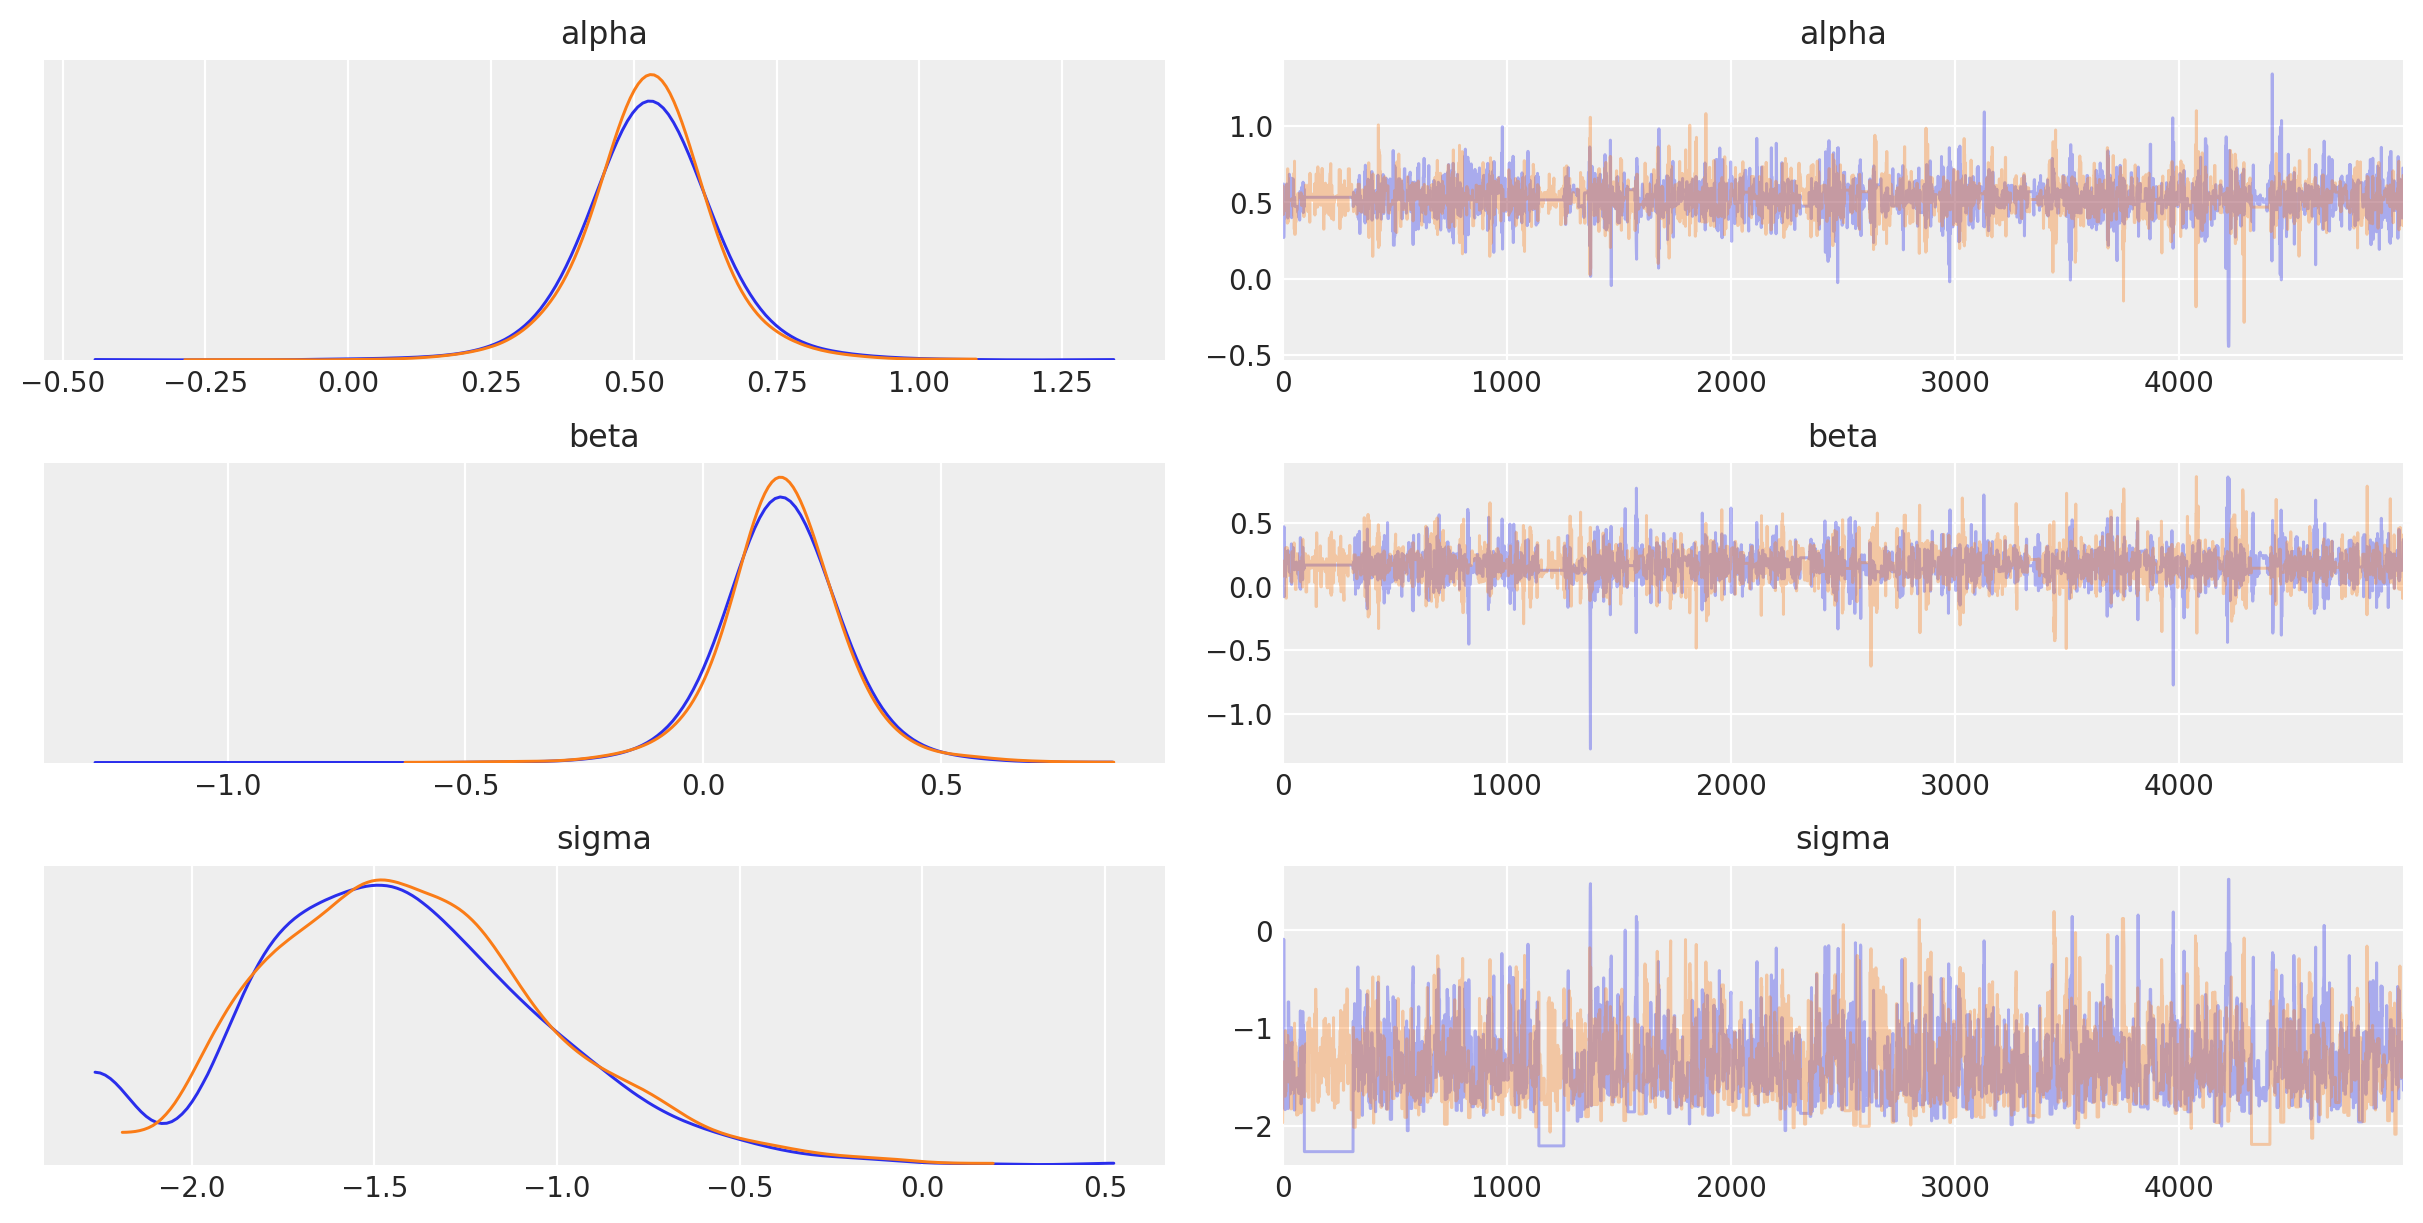

In [18]:
az.plot_trace(trace_7_1);

## Code 7.4 [TODO !]

Use OLS for the above model

## Code 7.5


Variance explained or $R^2$ is defined as:

$R^2$ = 1 - $\frac{var(residuals)}{var(outcome)}$

In [19]:
posterior = trace_7_1.posterior

# We will have to simulate (compute) our posterior brain_std from the samples
sample_alpha = posterior["alpha"].values[0]
sample_beta = posterior["beta"].values[0]
sample_sigma = posterior["sigma"].values[0]

def compute_mu(m):
    mu = sample_alpha + sample_beta * m
    return mu

mu = np.array(list(map(compute_mu, d.mass_std.values))).T
scale = sample_sigma[...,np.newaxis]

sample_brain_std = tfd.Normal(loc=mu, scale=tf.exp(scale)).sample()

# get the mean
brain_std_mean = np.mean(sample_brain_std, 0)

r = brain_std_mean - d.brain_std.values

# compute the variance expained (R square)
resid_var = np.var(r, ddof=1)
outcome_var = np.var(d.brain_std.values, ddof=1)
1 - resid_var / outcome_var

0.4972128022122041

## Code 7.6

$R^2$ is bad, the author says ! ... here is  resuable function that will used multiple times later

In [20]:
def RX_is_bad(mu_fn, scale):     
    # note - here we compute for the dataset and not the sequence
    mu = np.array(list(map(mu_fn, d.mass_std.values))).T    
    
    sample_brain_std = tfd.Normal(loc=mu, scale=scale).sample()
    
    # get the mean
    brain_std_mean = np.mean(sample_brain_std, 0)        
    r = brain_std_mean - d.brain_std.values
    # compute the variance expained (R square)
    resid_var = np.var(r, ddof=1)
    outcome_var = np.var(d.brain_std.values, ddof=1)
    return 1 - resid_var / outcome_var

## Code 7.7

Building some more models to compare to m7.1

This one is a poymomial of second degree

In [21]:
def model_7_2(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=2))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * mass_std ** 2
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

In [22]:
# will use this method for various models
def compute_brain_body_posterior_for_simulation(beta_degree, jdc):

    if beta_degree == 1:        
        init_state = [
            0.5 * tf.ones([NUMBER_OF_CHAINS]),
            tf.zeros([NUMBER_OF_CHAINS]),
            tf.zeros([NUMBER_OF_CHAINS]),
        ]
    else:    
        init_state = [
            0.5 * tf.ones([NUMBER_OF_CHAINS]),
            tf.zeros([NUMBER_OF_CHAINS, beta_degree]),
            tf.zeros([NUMBER_OF_CHAINS]),
        ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
    ]
    
    observed_data = (tf.cast(d["brain_std"].values, dtype=tf.float32),)

    trace= sample_from_posterior(
                        jdc, 
                        observed_data=observed_data,
                        params=['alpha', 'beta', 'sigma'],
                        num_samples=1000,
                        init_state=init_state,
                        bijectors=bijectors
                        )
    
    return trace

## Code 7.8

Models of 3rd, 4th and 5th degrees

In [23]:
def model_7_3(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=3))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * mass_std ** 2 + \
                                     beta3[...,tf.newaxis] * mass_std ** 3
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)
                                          
                                          
def model_7_4(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=4))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        beta4 = tf.squeeze(tf.gather(beta, [3], axis=-1))                                          
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * mass_std ** 2 + \
                                     beta3[...,tf.newaxis] * mass_std ** 3 + \
                                     beta4[...,tf.newaxis] * mass_std ** 4 
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

def model_7_5(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=5))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        beta4 = tf.squeeze(tf.gather(beta, [3], axis=-1))                                        
        beta5 = tf.squeeze(tf.gather(beta, [4], axis=-1))                                        
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * mass_std ** 2 + \
                                     beta3[...,tf.newaxis] * mass_std ** 3 + \
                                     beta4[...,tf.newaxis] * mass_std ** 4 + \
                                     beta5[...,tf.newaxis] * mass_std ** 5
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

## Code 7.9

This one is of degree 6 but the standard deviation has been replaced with constant 0.001. The author mentions that otherwise it will not work and will be explained with the help of plot later

In [24]:
def model_7_6(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=6))        
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        beta4 = tf.squeeze(tf.gather(beta, [3], axis=-1))                                        
        beta5 = tf.squeeze(tf.gather(beta, [4], axis=-1))    
        beta6 = tf.squeeze(tf.gather(beta, [5], axis=-1))    
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * mass_std ** 2 + \
                                     beta3[...,tf.newaxis] * mass_std ** 3 + \
                                     beta4[...,tf.newaxis] * mass_std ** 4 + \
                                     beta5[...,tf.newaxis] * mass_std ** 5 + \
                                     beta6[...,tf.newaxis] * mass_std ** 6        
        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=0.001), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

In [25]:
# for this method we need to compute the posterior differently as the model is different in terms of params
def compute_posterior_for_76_simulation(jdc_7_6):    

    init_state = [
        0.5 * tf.ones([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS, 6])
    ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity()
    ]
    
    observed_data = (tf.cast(d["brain_std"].values, dtype=tf.float32),)

    trace_7_6 = sample_from_posterior(
                        jdc_7_6, 
                        observed_data=observed_data,
                        params=['alpha', 'beta'],
                        num_samples=1000,
                        init_state=init_state,
                        bijectors=bijectors
                        )
    
    return trace_7_6

## Code 7.10

In [26]:
jdc_7_1 = model_7_1(d["mass_std"].values)
jdc_7_2 = model_7_2(d["mass_std"].values)
jdc_7_3 = model_7_3(d["mass_std"].values)
jdc_7_4 = model_7_4(d["mass_std"].values)
jdc_7_5 = model_7_5(d["mass_std"].values)    
jdc_7_6 = model_7_6(d["mass_std"].values)    

trace_7_1 = compute_brain_body_posterior_for_simulation(1, jdc_7_1)
trace_7_2 = compute_brain_body_posterior_for_simulation(2, jdc_7_2)
trace_7_3 = compute_brain_body_posterior_for_simulation(3, jdc_7_3)
trace_7_4 = compute_brain_body_posterior_for_simulation(4, jdc_7_4)
trace_7_5 = compute_brain_body_posterior_for_simulation(5, jdc_7_5)

trace_7_6 = compute_posterior_for_76_simulation(jdc_7_6)

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


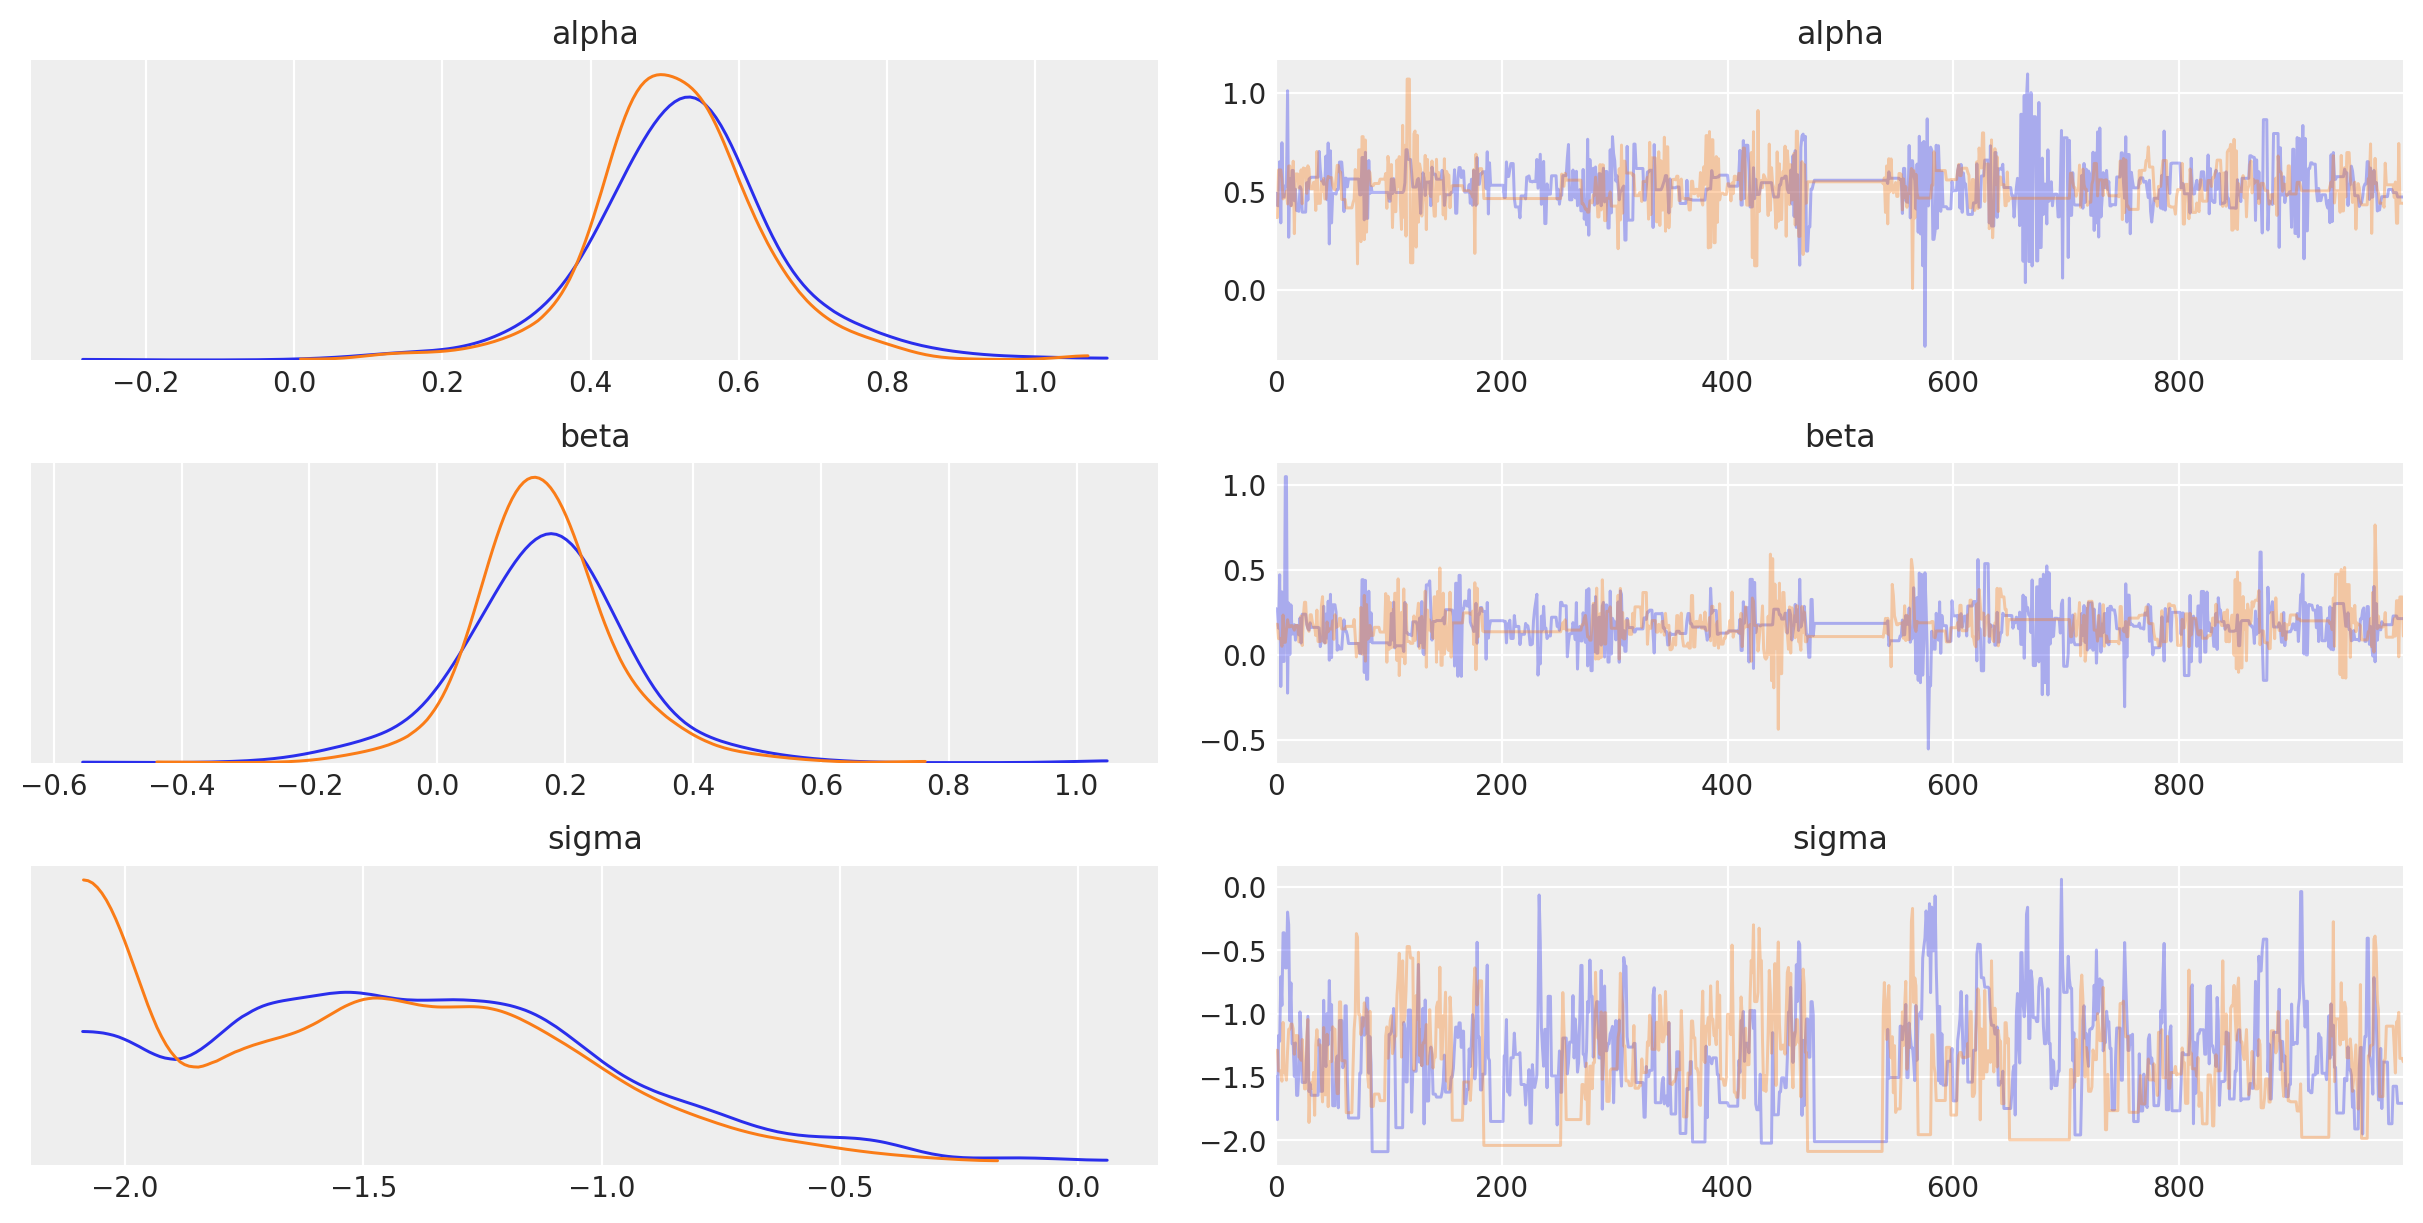

In [27]:
az.plot_trace(trace_7_1);

In [28]:
mass_seq = np.linspace(d.mass_std.min(), d.mass_std.max(), num=100)

In [29]:
def plot_model_mean(model_name, trace, predictor_fn):    
    mu_fn = predictor_fn()    
    mu = np.array(list(map(mu_fn, mass_seq))).T
    
    mu_mean = np.mean(mu, 0)
    mu_ci = np.percentile(mu, (4.5, 95.5), 0)
    
    plt.scatter(d.mass_std, d.brain_std, facecolors="b", edgecolors="b")
    plt.plot(mass_seq, mu_mean, "k")
    
    plt.fill_between(mass_seq, mu_ci[0], mu_ci[1], color="k", alpha=0.2)
    
    if "sigma" in trace.posterior:    
        sigma = trace.posterior["sigma"].values[0]
        scale = tf.exp(sigma[...,np.newaxis])
    else:
        scale = 0.001  # model number 6
    
    plt.title("{}: R^2 = {:0.2f}".format(model_name, RX_is_bad(mu_fn, scale).item()));    

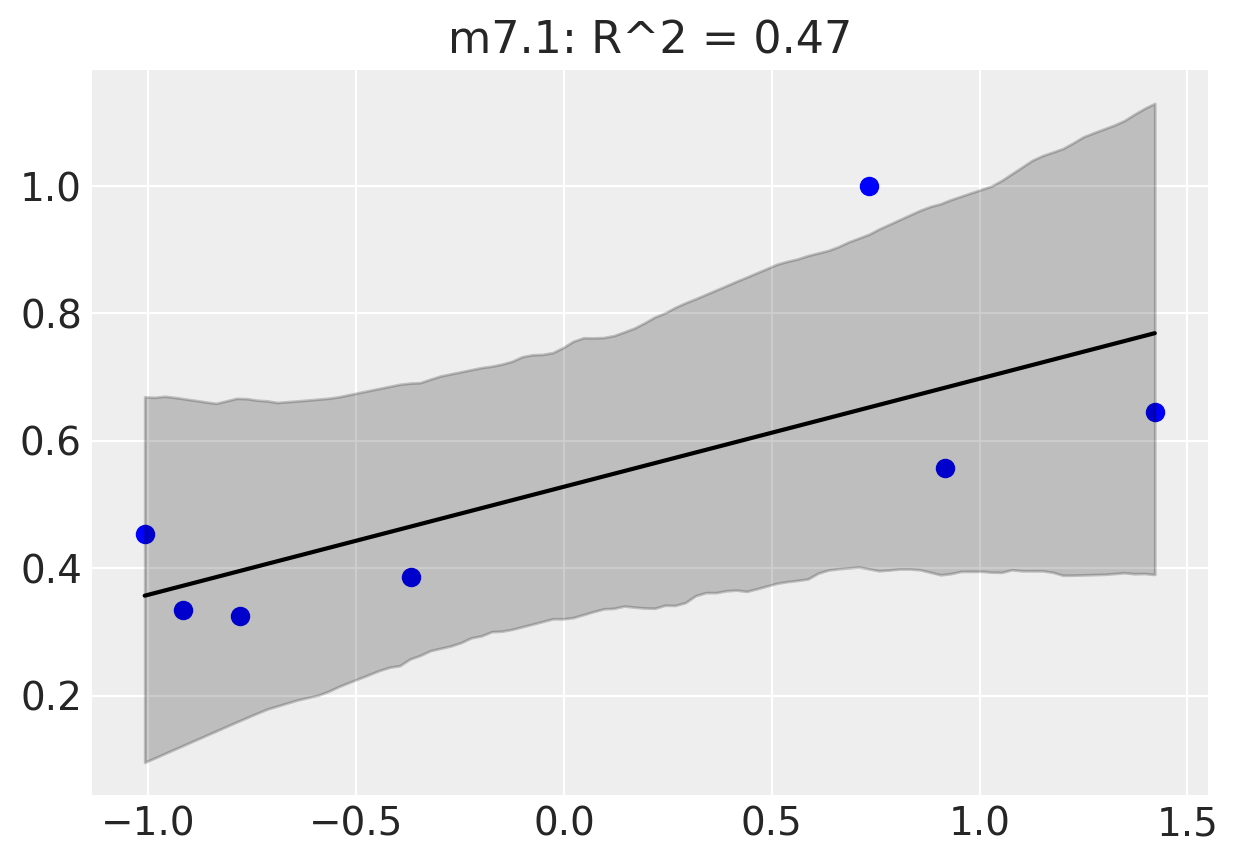

In [30]:
def predictor_m7_1(chain_idx=0):
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_1.posterior["alpha"].values[chain_idx]
    sample_beta = trace_7_1.posterior["beta"].values[chain_idx]    
    
    def compute_mu71(m):
        mu = sample_alpha + sample_beta * m        
        return mu    

    return compute_mu71
    
    
plot_model_mean("m7.1", trace_7_1, predictor_m7_1)

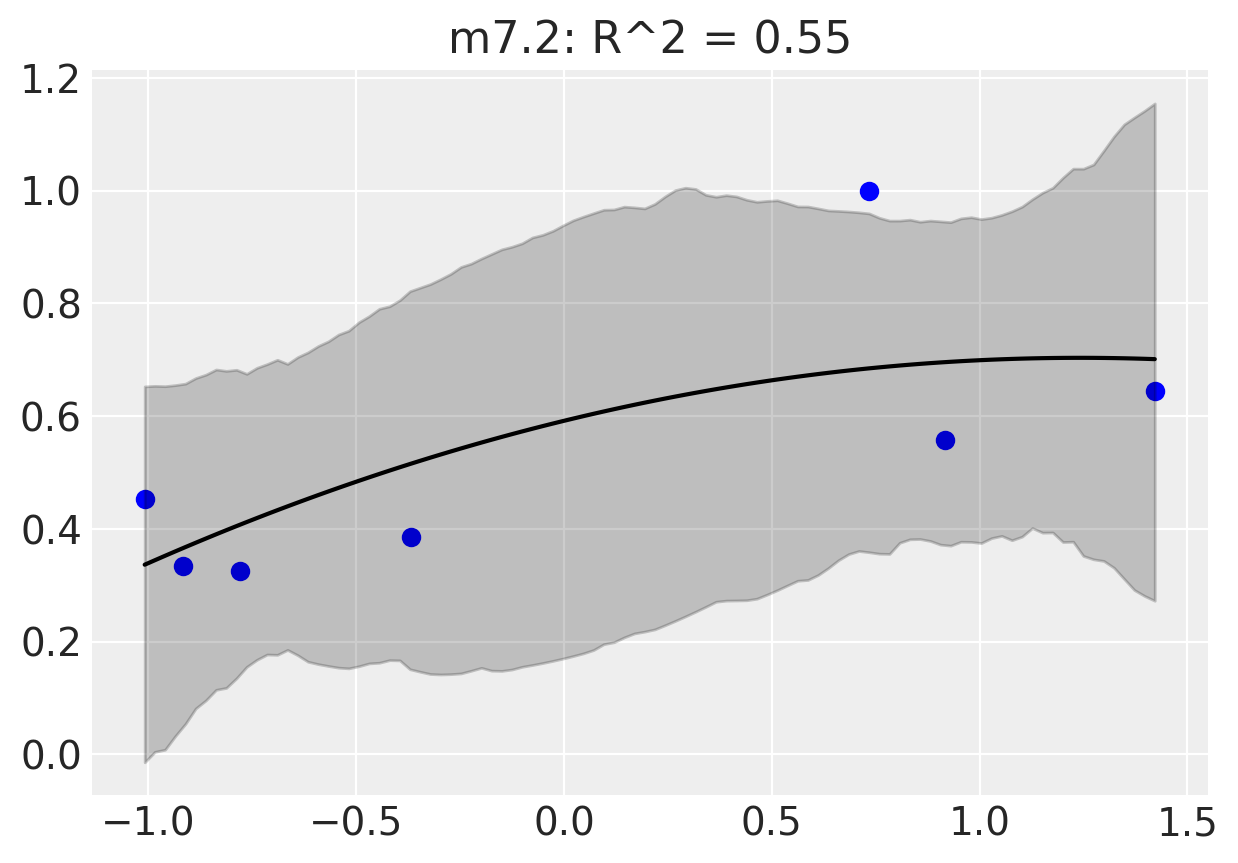

In [31]:
# Book does not provide the code snippet for other models but has corresponding figures so I am 
# doing that as well

def predictor_m7_2(chain_idx=0):
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_2.posterior["alpha"].values[chain_idx]
    sample_beta = trace_7_2.posterior["beta"].values[chain_idx]        
    
    def compute_mu72(m):        
        mu = sample_alpha + sample_beta[:,0] * m +\
                            sample_beta[:,1] * m ** 2
        return mu
    
    return compute_mu72
    
    
plot_model_mean("m7.2", trace_7_2, predictor_m7_2)

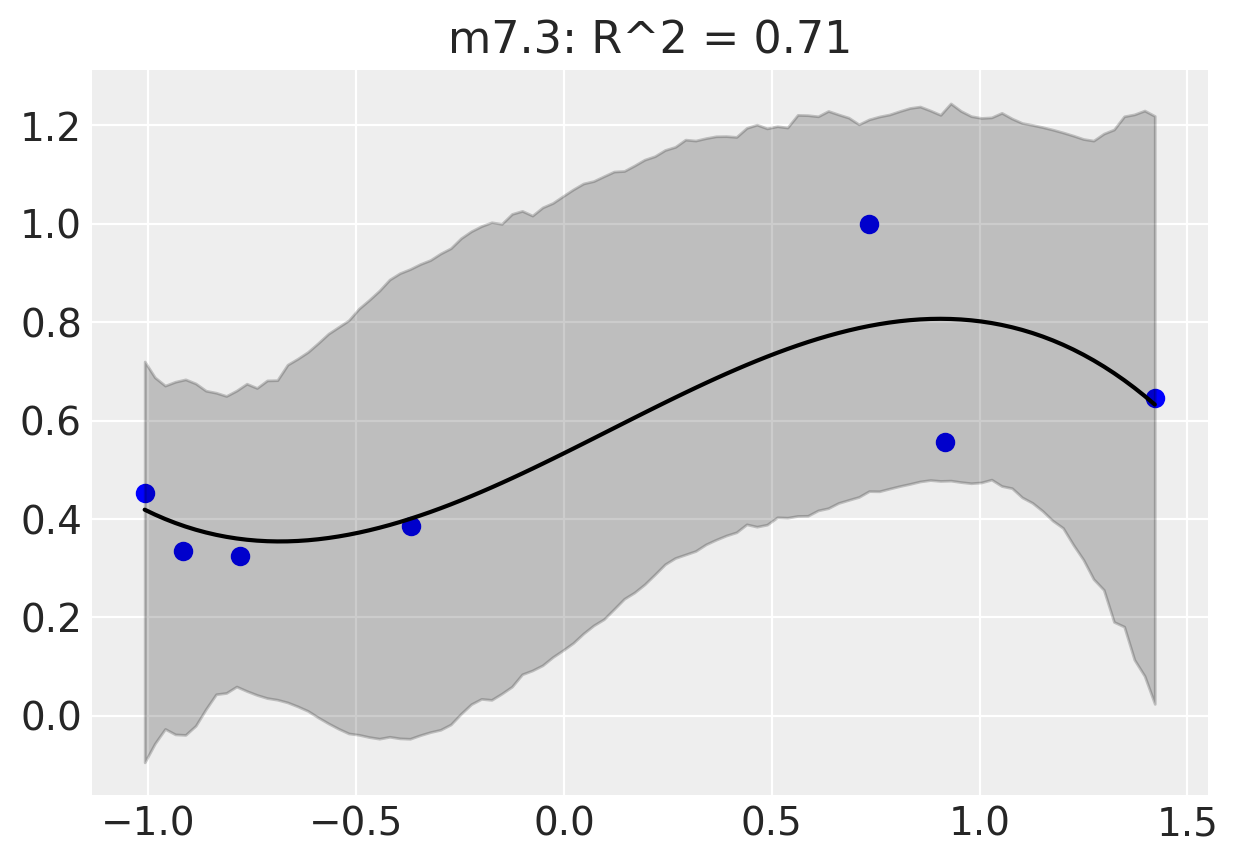

In [32]:
def predictor_m7_3(chain_idx=0):
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_3.posterior["alpha"].values[chain_idx]
    sample_beta = trace_7_3.posterior["beta"].values[chain_idx]        
    
    def compute_mu(m):
        mu = sample_alpha + sample_beta[:,0] * m + \
                            sample_beta[:,1] * m **2 +\
                            sample_beta[:,2] * m **3
        return mu   
    
    return compute_mu
    
    
plot_model_mean("m7.3", trace_7_3, predictor_m7_3)

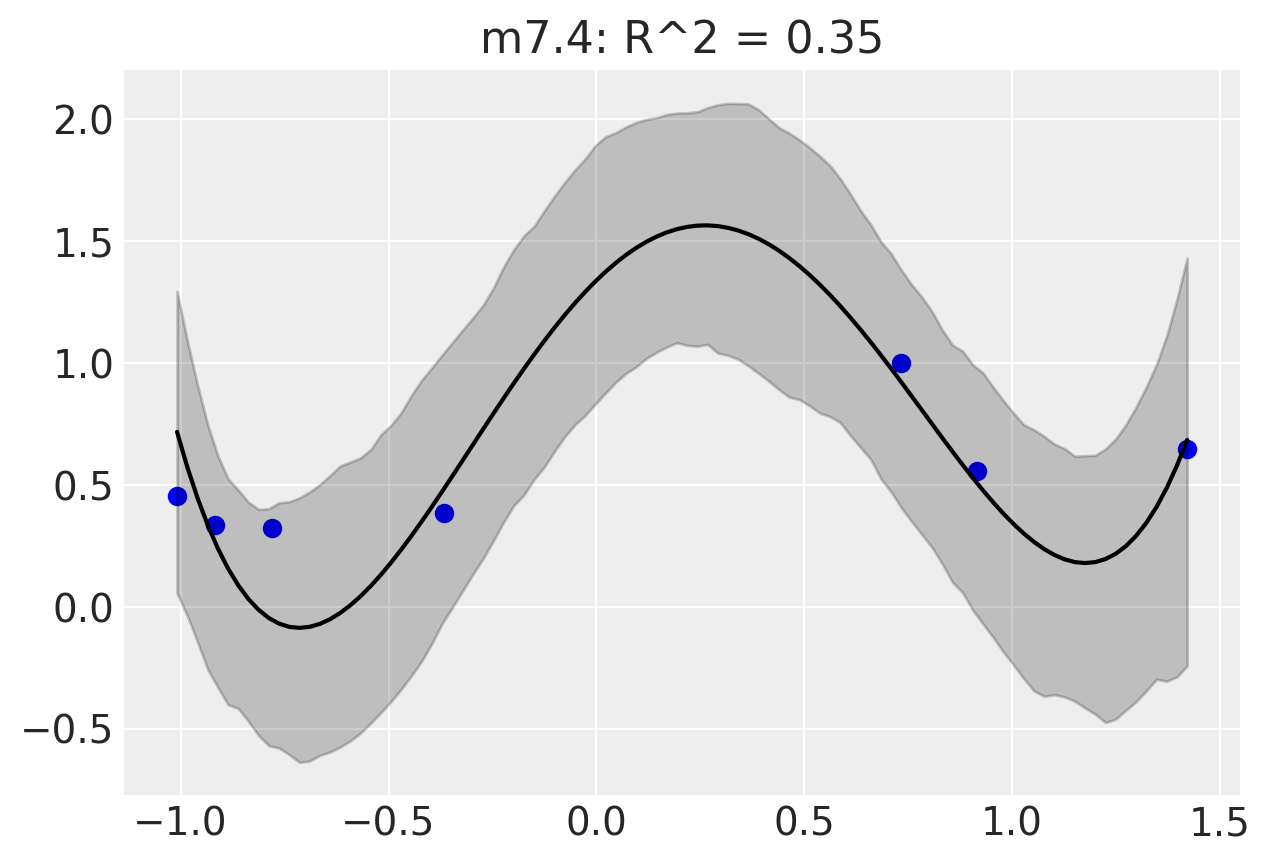

In [33]:
def predictor_m7_4(chain_idx=0):
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_4.posterior["alpha"].values[chain_idx]
    sample_beta = trace_7_4.posterior["beta"].values[chain_idx]    
    
    def compute_mu(m):
        mu = sample_alpha + sample_beta[:,0] * m + \
                            sample_beta[:,1] * m ** 2 + \
                            sample_beta[:,2] * m ** 3 + \
                            sample_beta[:,3] * m ** 4
        return mu
    
    return compute_mu
    
    
plot_model_mean("m7.4", trace_7_4, predictor_m7_4)

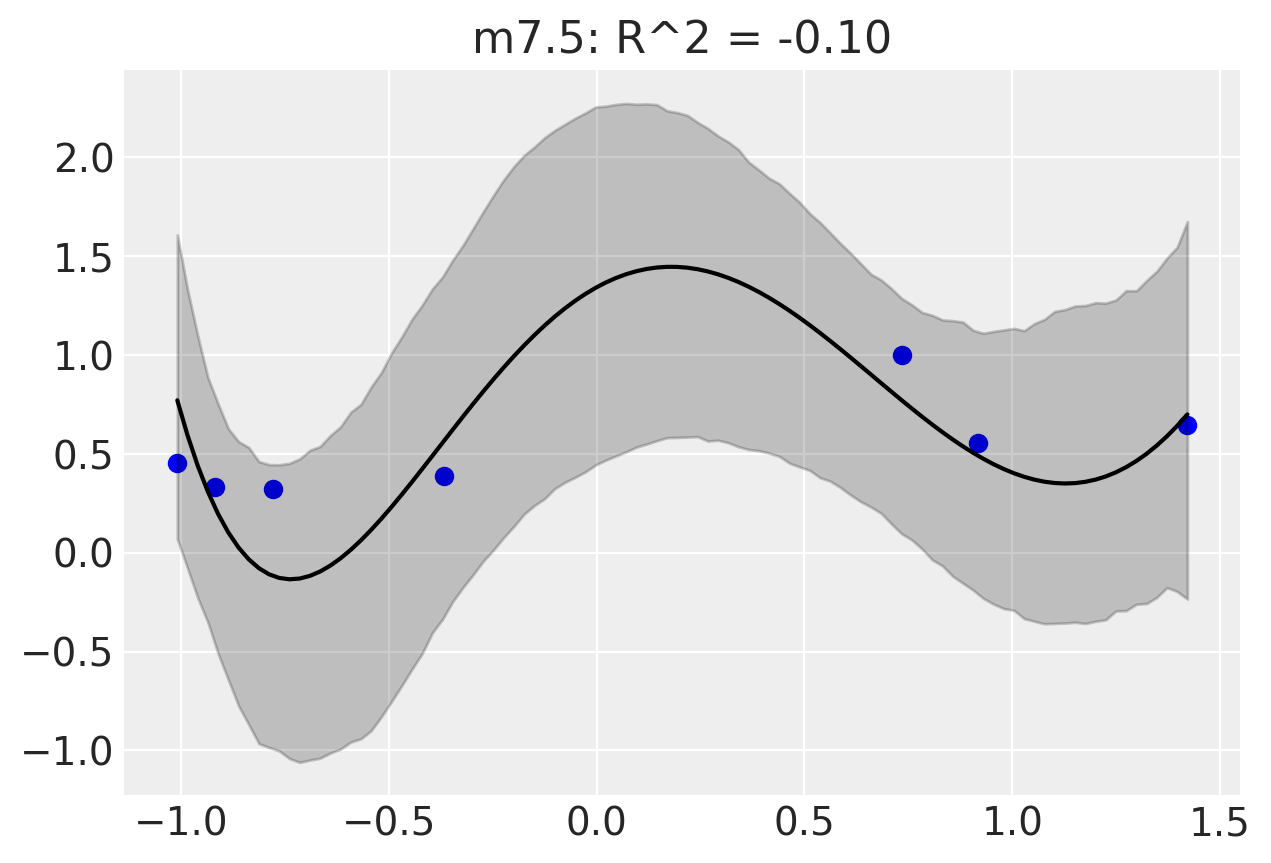

In [34]:
def predictor_m7_5(chain_idx=0):
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_5.posterior["alpha"].values[chain_idx]
    sample_beta = trace_7_5.posterior["beta"].values[chain_idx]        
    
    def compute_mu(m):
        mu = sample_alpha + sample_beta[:,0] * m + \
                            sample_beta[:,1] * m ** 2 + \
                            sample_beta[:,2] * m ** 3 + \
                            sample_beta[:,3] * m ** 4 + \
                            sample_beta[:,4] * m ** 5 
        return mu    
    
    return compute_mu
    
    
plot_model_mean("m7.5", trace_7_5, predictor_m7_5)

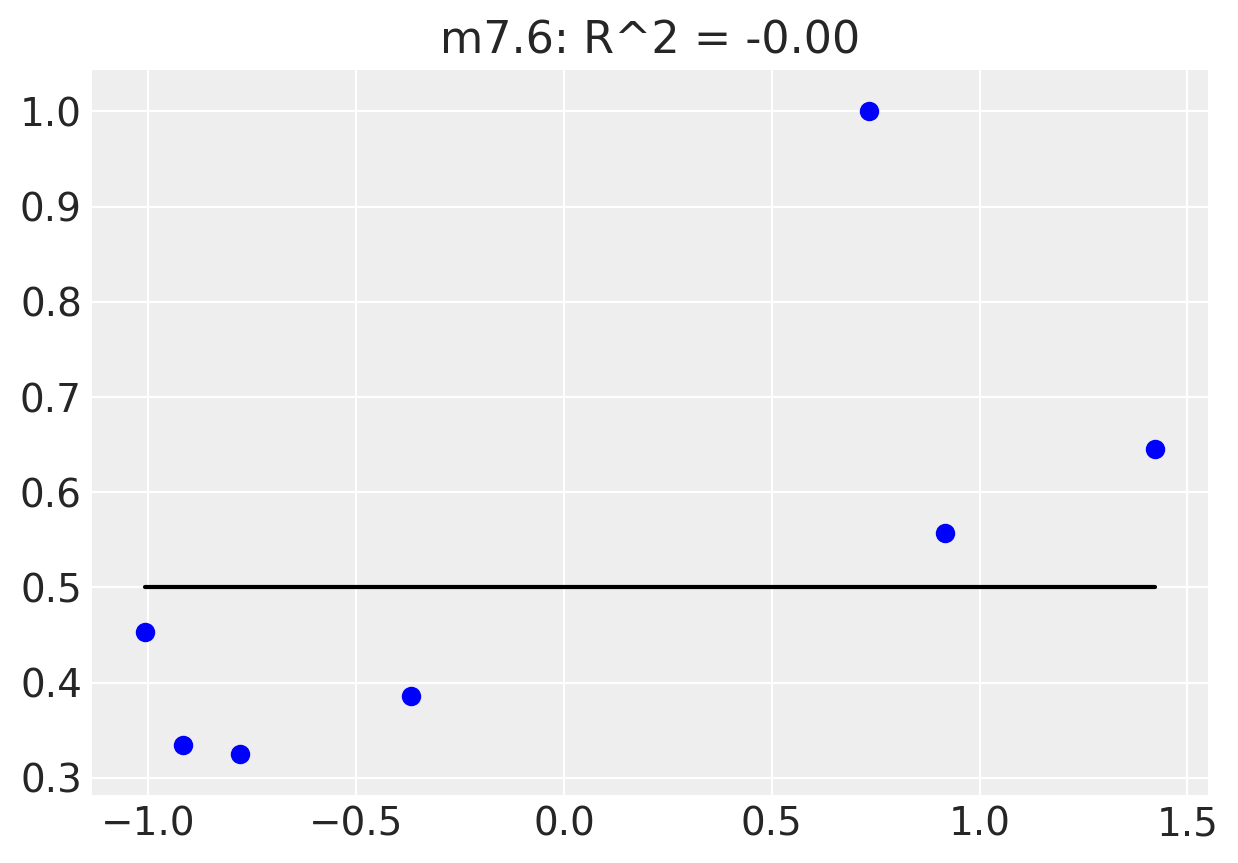

In [35]:
def predictor_m7_6(chain_idx=0):
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_6.posterior["alpha"].values[chain_idx]
    sample_beta = trace_7_6.posterior["beta"].values[chain_idx]        
    
    def compute_mu(m):
        mu = sample_alpha + sample_beta[:,0] * m + \
                            sample_beta[:,1] * m ** 2 + \
                            sample_beta[:,2] * m ** 3 + \
                            sample_beta[:,3] * m ** 4 + \
                            sample_beta[:,4] * m ** 5 + \
                            sample_beta[:,5] * m ** 6
        return mu   
    
    return compute_mu
    
    
plot_model_mean("m7.6", trace_7_6, predictor_m7_6)

## Code 7.11

In [36]:
i = 1
d_minus_i = d.drop(i)

## Code 7.12

In [37]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

## Code 7.13

In [38]:
def compute_log_likelihood(trace, predictor_fn):    

    log_likelihood_total = []

    for i in range(NUMBER_OF_CHAINS):                
        mu_fn = predictor_fn(i) 
        sigma = trace.posterior["sigma"].values[i]
        scale = tf.exp(sigma[...,np.newaxis])
        
        mu = np.array(list(map(mu_fn, d.mass_std.values))).T
        
        ll = tfd.Normal(
            loc=tf.cast(mu, dtype=tf.float32),
            scale=tf.cast(scale, dtype=tf.float32)).log_prob(d.brain_std.values)                
        
        log_likelihood_total.append(ll)

    log_likelihood_total = np.array(log_likelihood_total)
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(7)]
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    print(log_likelihood_total.shape)
    
    return log_likelihood_total

def lppd_fn(trace, predictor_fn):
    ll = compute_log_likelihood(trace, predictor_fn)
    ll = tf.math.reduce_logsumexp(ll, 0) - tf.math.log(tf.cast(ll.shape[0], dtype=tf.float32))
    return np.mean(ll,0)


lppd_fn(trace_7_1, predictor_m7_1)

(2, 1000, 7)


array([ 0.40120298,  0.42398834,  0.29055974,  0.4199552 ,  0.28088284,
        0.22431433, -0.88906056], dtype=float32)

## Code 7.14

This is simply an implementation of lppd_fn which I have done in 7.13 already

## Code 7.15

In [39]:
ite = ((trace_7_1, predictor_m7_1), 
       (trace_7_2, predictor_m7_2), 
       (trace_7_3, predictor_m7_3),
       (trace_7_3, predictor_m7_4),
       (trace_7_3, predictor_m7_5))

In [40]:
[np.sum(lppd_fn(m[0],m[1])) for m in ite]

(2, 1000, 7)
(2, 1000, 7)
(2, 1000, 7)
(2, 1000, 7)
(2, 1000, 7)


[1.1518431, 0.60287094, -0.097639635, -0.8501073, -3.6564415]

## Code 7.16 - 7.18 [TODO]

## Code 7.19

In [41]:
d = pd.read_csv(CARS_DATASET_PATH, sep=",")

d

,Unnamed: 0,speed,dist
0,1,4,2
1,2,4,10
2,3,7,4
3,4,7,22
4,5,8,16
5,6,9,10
6,7,10,18
7,8,10,26
8,9,10,34
9,10,11,17


In [42]:
# Note - 
#
# In first edition, the book used Uniform for sigma and in the second
# edition it is using Exponential; 
#
# If I use exponential the chains do not converge; the traces are seriously bad
# so using the model form edition 1 here

def cars_model(speed):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=100., name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=1))
#         sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma") , sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=30., name="sigma") , sample_shape=1))
        
        
        mu = alpha[...,tf.newaxis] + beta[...,tf.newaxis] * speed
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

In [43]:
jdc_cars = cars_model(tf.cast(d.speed.values, dtype=tf.float32))

init_state = [
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.ones([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
]

observed_data = (tf.cast(d.dist.values, dtype=tf.float32),)

# here I am increasing the sampling size
# to see if that helps
trace_cars = sample_from_posterior(
                    jdc_cars, 
                    observed_data=observed_data,
                    params=['alpha', 'beta', 'sigma'],
                    num_samples=5000,
                    burnin=5000,
                    init_state=init_state,
                    bijectors=bijectors
                    )

In [44]:
az.summary(trace_cars)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-16.837,5.341,-26.415,-7.556,0.901,0.73,35.0,27.0,39.0,126.0,1.08
beta,3.888,0.340,3.251,4.496,0.053,0.04,42.0,37.0,46.0,106.0,1.07
sigma,15.741,1.681,12.761,18.977,0.071,0.05,559.0,559.0,566.0,828.0,1.00


/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


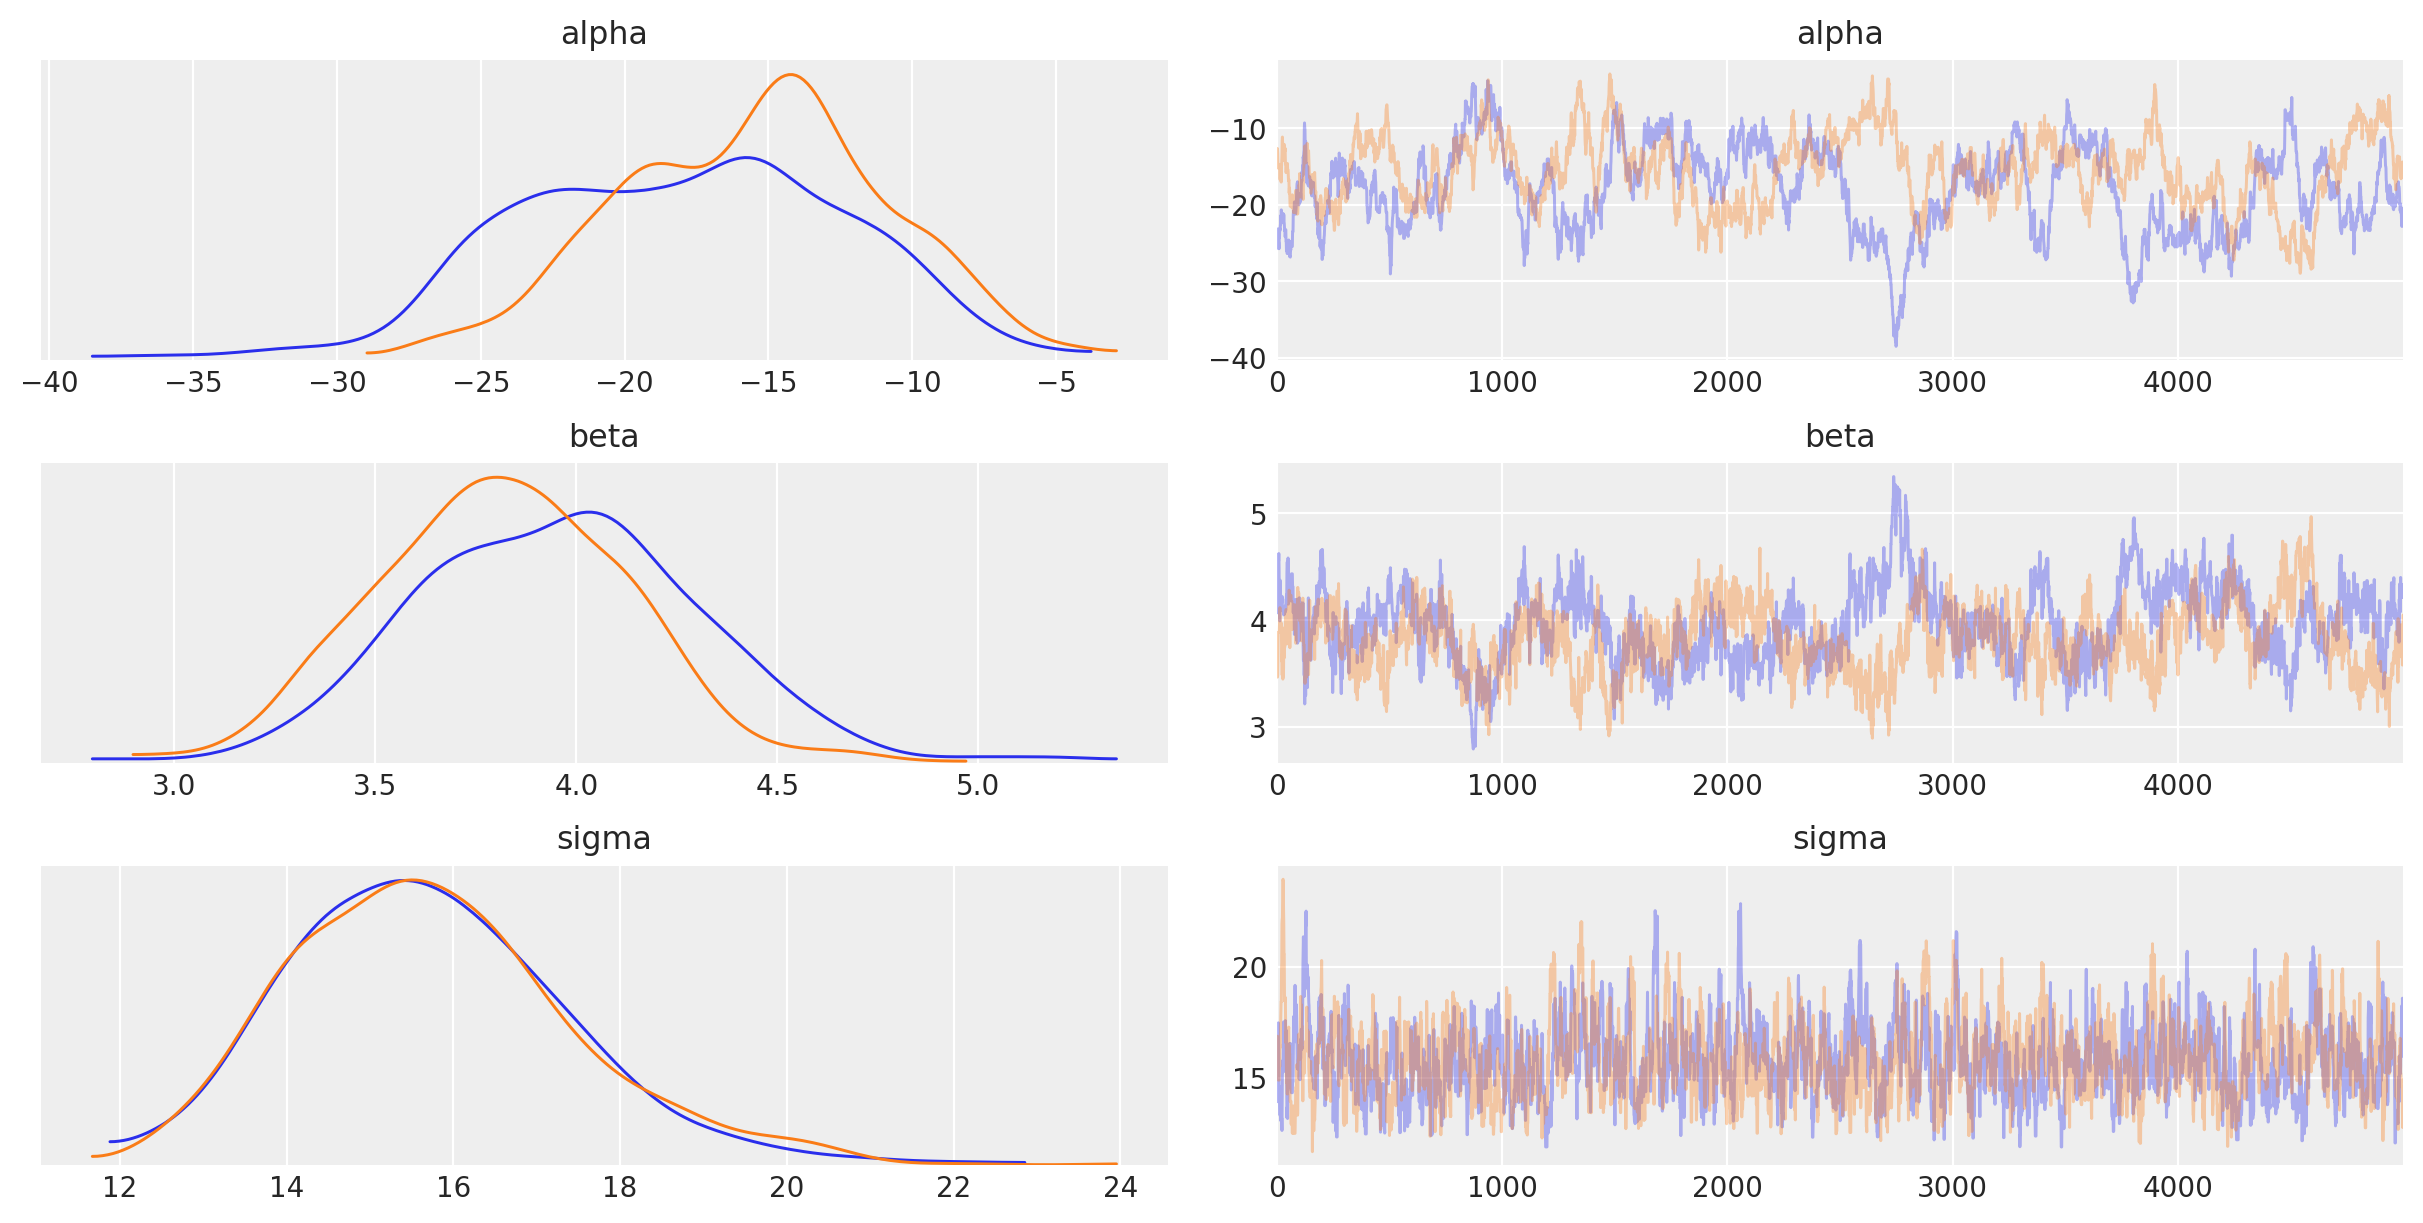

In [45]:
az.plot_trace(trace_cars);

## Code 7.20

In [46]:
n_samples = 2000
post = trace_cars.posterior

def logprob_fn(s):
    mu = post["alpha"].values[0][s] + post["beta"].values[0][s] * d.speed.values
    sigma = post["sigma"].values[0][s]
    scale = sigma   
    
    return tfd.Normal(
        loc=tf.cast(mu, dtype=tf.float32), 
        scale=tf.cast(scale, dtype=tf.float32)).log_prob(d.dist.values)

logprob = np.array(list(map(logprob_fn, np.arange(n_samples)))).T

logprob.shape

(50, 2000)

## Code 7.21

In [47]:
n_cases = d.shape[0]
lppd = tf.math.reduce_logsumexp(logprob, 1) - tf.math.log(tf.cast(n_samples, dtype=tf.float32))

## Code 7.22

In [48]:
pWAIC = np.var(logprob, 1)

## Code 7.23

In [49]:
-2 * (np.sum(lppd) - np.sum(pWAIC))

418.92657470703125

## Code 7.24

In [50]:
waic_vec = -2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

12.64672427152412

## Code 7.25 - 31 (TODO)

## Code 7.32

In [51]:
d = pd.read_csv(WAFFLE_DIVORCE_DATASET_PATH, sep=";")
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

In [52]:
def model_5_1(A):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.2, name="alpha"), sample_shape=1))
        betaA = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaA"), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaA[...,tf.newaxis] * A
        scale = sigma[...,tf.newaxis]
        
        D = yield tfd.Independent(tfd.Normal(loc=mu,scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

def model_5_2(M):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.2, name="alpha"), sample_shape=1))
        betaM = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaM"), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaM[...,tf.newaxis] * M
        scale = sigma[...,tf.newaxis]
        
        D = yield tfd.Independent(tfd.Normal(loc=mu,scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)
        
    
def model_5_3(A, M):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.2, name="alpha"), sample_shape=1))
        betaA = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaA"), sample_shape=1))
        betaM = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaM"), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaA[...,tf.newaxis] * A +  betaM[...,tf.newaxis] * M
        scale = sigma[...,tf.newaxis]
        
        D = yield tfd.Independent(tfd.Normal(loc=mu,scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)


jdc_5_1 = model_5_1(d.A.values)
jdc_5_2 = model_5_2(d.M.values)
jdc_5_3 = model_5_3(d.A.values, d.M.values)


def compute_posterior_5_1_and_2(jdc):
    init_state = [
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.ones([NUMBER_OF_CHAINS]),
    ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp(),
    ]

    observed_data = (tf.cast(d.D.values, dtype=tf.float32),)

    # here I am increasing the sampling size
    # to see if that helps
    trace = sample_from_posterior(
                        jdc, 
                        observed_data=observed_data,
                        params=['alpha', 'beta', 'sigma'],
                        num_samples=1000,
                        burnin=500,
                        init_state=init_state,
                        bijectors=bijectors
                        )
    
    return trace

def computer_posterior_5_3():
    init_state = [
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.ones([NUMBER_OF_CHAINS]),
    ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp(),
    ]

    observed_data = (tf.cast(d.D.values, dtype=tf.float32),)

    # here I am increasing the sampling size
    # to see if that helps
    trace = sample_from_posterior(
                        jdc_5_3, 
                        observed_data=observed_data,
                        params=['alpha', 'betaA', 'betaM', 'sigma'],
                        num_samples=1000,
                        burnin=500,
                        init_state=init_state,
                        bijectors=bijectors
                        )
    
    return trace
        
    
trace_5_1 = compute_posterior_5_1_and_2(jdc_5_1)
trace_5_2 = compute_posterior_5_1_and_2(jdc_5_2)
trace_5_3 = computer_posterior_5_3()


## Code 7.33

In [53]:
def compute_log_likelihood_5_1_2(trace, predictor_fn, observed_values):    

    log_likelihood_total = []

    for i in range(NUMBER_OF_CHAINS):                
        mu_fn = predictor_fn(i) 
        sigma = trace.posterior["sigma"].values[i]
        scale = sigma[...,np.newaxis]
        
        mu = np.array(list(map(mu_fn, observed_values))).T
        
        ll = tfd.Normal(
            loc=tf.cast(mu, dtype=tf.float32),
            scale=tf.cast(scale, dtype=tf.float32)).log_prob(d.D.values)                
        
        log_likelihood_total.append(ll)

    log_likelihood_total = np.array(log_likelihood_total)
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(50)]
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    return log_likelihood_total

def compute_log_likelihood_5_3(predictor_fn):    

    log_likelihood_total = []

    for i in range(NUMBER_OF_CHAINS):                
        mu_fn = predictor_fn(i) 
        sigma = trace_5_3.posterior["sigma"].values[i]
        scale = sigma[...,np.newaxis]
        
        params = zip(d.A.values, d.M.values)
        
        mu = np.array(list(map(mu_fn, params))).T
        
        ll = tfd.Normal(
            loc=tf.cast(mu, dtype=tf.float32),
            scale=tf.cast(scale, dtype=tf.float32)).log_prob(d.D.values)                
        
        log_likelihood_total.append(ll)

    log_likelihood_total = np.array(log_likelihood_total)
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace_5_3.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(50)]
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    return log_likelihood_total


def predictor_m5_1(chain_idx=0):
    sample_alpha = trace_5_1.posterior["alpha"].values[chain_idx]
    sample_beta = trace_5_1.posterior["beta"].values[chain_idx]        
    
    def compute_mu(a):        
        mu = sample_alpha + sample_beta * a 
        return mu
    
    return compute_mu

def predictor_m5_2(chain_idx=0):
    sample_alpha = trace_5_2.posterior["alpha"].values[chain_idx]
    sample_beta = trace_5_2.posterior["beta"].values[chain_idx]        
    
    def compute_mu(m):        
        mu = sample_alpha + sample_beta * m 
        return mu
    
    return compute_mu

def predictor_m5_3(chain_idx=0):
    sample_alpha = trace_5_3.posterior["alpha"].values[chain_idx]
    sample_betaA = trace_5_3.posterior["betaA"].values[chain_idx]        
    sample_betaM = trace_5_3.posterior["betaM"].values[chain_idx]        
    
    def compute_mu(params):
        a = params[0]
        m = params[1]
        mu = sample_alpha + sample_betaA * a + sample_betaM * m 
        return mu
    
    return compute_mu

In [54]:
ll_5_1 = compute_log_likelihood_5_1_2(trace_5_1, predictor_m5_1, d.A.values)

In [55]:
ll_5_2 = compute_log_likelihood_5_1_2(trace_5_2, predictor_m5_2, d.M.values)

In [56]:
ll_5_3 = compute_log_likelihood_5_3(predictor_m5_3)

In [57]:
az.compare({"m5.1": trace_5_1, "m5.2": trace_5_2, 'm5.3' : trace_5_3})

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m5.1,0,125.509,3.49833,0,0.710686,13.3279,0,True,deviance
m5.3,1,128.306,5.13438,2.79703,0.189244,10.1452,0.764738,True,deviance
m5.2,2,138.368,2.55881,12.8586,0.10007,13.7178,9.02346,True,deviance


## Code 7.34

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


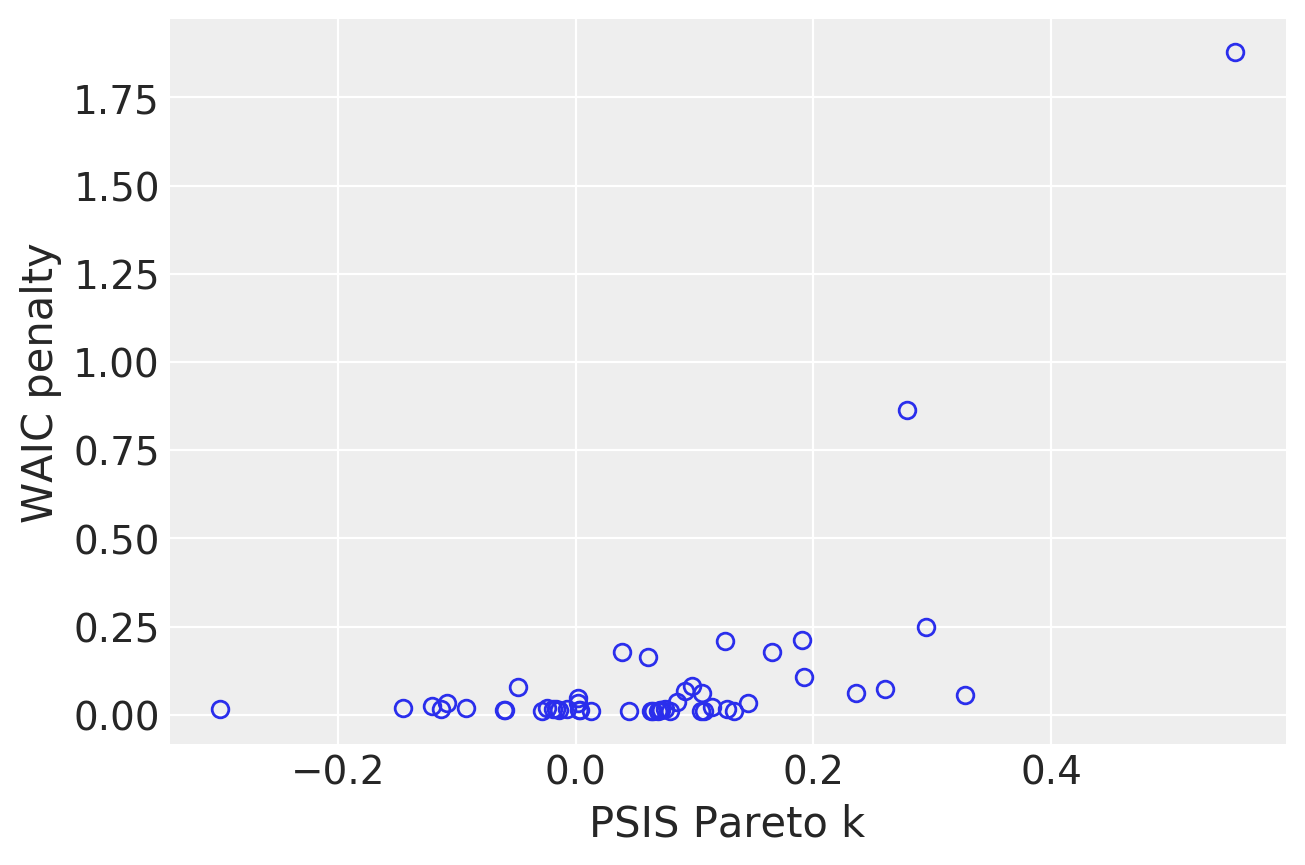

In [58]:
PSIS_m5_3 = az.loo(trace_5_3, pointwise=True)
WAIC_m5_3 = az.waic(trace_5_3, pointwise=True)
penalty = trace_5_3.sample_stats.log_likelihood.stack(
    sample=("chain", "draw")).var(dim="sample").values
plt.plot(PSIS_m5_3.pareto_k.values, penalty, "o", mfc="none")
plt.gca().set(xlabel="PSIS Pareto k", ylabel="WAIC penalty");

## Code 7.35

In [59]:
def model_5_3t(A, M):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.2, name="alpha"), sample_shape=1))
        betaA = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaA"), sample_shape=1))
        betaM = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaM"), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaA[...,tf.newaxis] * A +  betaM[...,tf.newaxis] * M
        scale = sigma[...,tf.newaxis]
        
        D = yield tfd.Independent(tfd.StudentT(df=2., loc=mu,scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)


jdc_5_3t = model_5_3t(d.A.values, d.M.values)

def computer_posterior_5_3t():
    init_state = [
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.ones([NUMBER_OF_CHAINS]),
    ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp(),
    ]

    observed_data = (tf.cast(d.D.values, dtype=tf.float32),)

    # here I am increasing the sampling size
    # to see if that helps
    trace = sample_from_posterior(
                        jdc_5_3t, 
                        observed_data=observed_data,
                        params=['alpha', 'betaA', 'betaM', 'sigma'],
                        num_samples=1000,
                        burnin=500,
                        init_state=init_state,
                        bijectors=bijectors
                        )
    
    return trace

trace_5_3t = computer_posterior_5_3t()

def compute_log_likelihood_5_3t(predictor_fn):    

    log_likelihood_total = []

    for i in range(NUMBER_OF_CHAINS):                
        mu_fn = predictor_fn(i) 
        sigma = trace_5_3t.posterior["sigma"].values[i]
        scale = sigma[...,np.newaxis]
        
        params = zip(d.A.values, d.M.values)
        
        mu = np.array(list(map(mu_fn, params))).T
        
        ll = tfd.StudentT(
            df=2.,
            loc=tf.cast(mu, dtype=tf.float32),
            scale=tf.cast(scale, dtype=tf.float32)).log_prob(d.D.values)                
        
        log_likelihood_total.append(ll)

    log_likelihood_total = np.array(log_likelihood_total)
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace_5_3t.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(50)]
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    return log_likelihood_total

def predictor_m5_3t(chain_idx=0):
    sample_alpha = trace_5_3.posterior["alpha"].values[chain_idx]
    sample_betaA = trace_5_3.posterior["betaA"].values[chain_idx]        
    sample_betaM = trace_5_3.posterior["betaM"].values[chain_idx]        
    
    def compute_mu(params):
        a = params[0]
        m = params[1]
        mu = sample_alpha + sample_betaA * a + sample_betaM * m 
        return mu
    
    return compute_mu

ll = compute_log_likelihood_5_3t(predictor_m5_3t)

In [60]:
az.compare({'m5.3' : trace_5_3, 'm5.3t' : trace_5_3t})

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m5.3,0,128.306,5.13438,0,0.758831,12.8155,0,True,deviance
m5.3t,1,132.504,4.32908,4.19727,0.241169,10.8858,5.72354,False,deviance


In [61]:
az.summary(trace_5_3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.003,0.100,-0.188,0.175,0.002,0.004,1790.0,392.0,1835.0,745.0,1.00
betaA,-0.606,0.166,-0.941,-0.311,0.007,0.006,554.0,429.0,569.0,172.0,1.00
betaM,-0.059,0.166,-0.397,0.227,0.006,0.006,750.0,372.0,757.0,333.0,1.00
sigma,0.827,0.092,0.655,0.990,0.002,0.001,2846.0,2254.0,3552.0,490.0,1.01


In [62]:
az.summary(trace_5_3t)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.029,0.101,-0.152,0.225,0.009,0.006,129.0,129.0,129.0,248.0,1.01
betaA,-0.697,0.149,-1.001,-0.437,0.005,0.004,749.0,596.0,758.0,257.0,1.01
betaM,0.050,0.197,-0.291,0.402,0.006,0.006,1272.0,584.0,1212.0,495.0,1.00
sigma,0.580,0.081,0.431,0.732,0.002,0.002,1393.0,1075.0,1406.0,143.0,1.02
